In [1]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import glob
import scipy
import re
import random
import time
import os
from itertools import chain

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


from scipy.stats import ttest_ind
from scipy.stats import norm
from scipy.spatial.distance import cdist


from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import PredictionErrorDisplay
from sklearn.metrics import roc_curve,RocCurveDisplay


from sklearn.model_selection import KFold
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import StratifiedKFold

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.optimize import minimize
from scipy.stats import spearmanr,rankdata,pearsonr

import scipy

pd.options.display.max_rows = 20
pd.options.display.float_format = "{:.3f}".format

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 8)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 9
cm = 1/2.54
fig_folder = './Figure_5_exports'
data_folder = '../all_data/Figure_5_data'


In [3]:
meta = pd.read_excel('../all_data/General_data/protein_metadata.xlsx')
meta = meta.rename(columns={'DNA_name':'Protein name'})
meta
low = ['B2AR','B3AR','CD63','CD81','CML1','CRCM','Cx43','FFAR4','Neu','OR1D2','OR1E1','OR2AG1']

meta['label'] = meta['Protein name'].apply(lambda x: 'bad' if x in low else 'good')
meta

,uniprot,Protein name,Organism,Length,tm_count,Mass,label
0,P60844,AqpZ,E. coli,231,6,23.703,good
1,F4HWB6,Aux,A. thaliana,472,10,51.877,good
2,P07550,B2AR,H. sapiens,413,7,46.459,bad
3,P13945,B3AR,H. sapiens,408,7,43.519,bad
4,Q9LTG0,Beta,A. thaliana,303,4,33.777,good
...,...,...,...,...,...,...,...
26,P0AGA2,SecYE-G,E. coli,443,12,48.512,good
27,Q5JW98,Vol,H. sapiens,314,4,35.060,good
28,Q8RXN3,PPT1,A. thaliana,408,8,44.200,good
29,Q96247,AuxT1,A. thaliana,485,11,54.100,good


In [5]:
metrics = pd.read_excel(data_folder+'/uniprot_ids_metrics.xlsx')
metrics = metrics.set_index('uniprot').join(meta[['uniprot','Protein name','label']].set_index('uniprot')).reset_index()

metrics

,uniprot,inner-inside-charge-Max,inner-inside-charge-Mean,inner-inside-charge-Min,inner-inside-charge-Sum,inner-inside-depth_6-Max,inner-inside-depth_6-Mean,inner-inside-depth_6-Min,inner-inside-depth_6-Sum,inner-inside-hydrophobicity-Max,...,water-outside-hydrophobicity-Max,water-outside-hydrophobicity-Mean,water-outside-hydrophobicity-Min,water-outside-hydrophobicity-Sum,water-outside-prob-Max,water-outside-prob-Mean,water-outside-prob-Min,water-outside-prob-Sum,Protein name,label
0,A0A075B734,1,0.000,-1,0,16,12.364,9,680,2.020,...,2.020,0.051,-1.850,0.720,4.183,2.667,1.376,37.341,NaN,NaN
1,A0A087WTH1,0,0.000,0,0,10,9.143,9,64,0.170,...,0.170,0.170,0.170,0.170,4.809,4.809,4.809,4.809,NaN,NaN
2,A0A096LPK9,0,-0.049,-1,-2,16,11.415,9,468,2.020,...,0.450,0.010,-0.240,0.050,5.472,3.382,2.471,16.908,NaN,NaN
3,A0A0X1KG70,1,-0.021,-1,-1,15,11.383,9,535,2.020,...,0.990,0.052,-1.130,0.470,5.472,3.079,2.165,27.711,NaN,NaN
4,A0A1B0GTI8,0,0.000,0,0,14,11.167,9,201,0.450,...,2.020,0.494,-1.130,7.900,5.746,2.511,1.376,40.170,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4607,Q9ZWB9,1,0.143,-1,3,15,12.095,10,254,1.230,...,2.020,0.351,-1.850,68.190,6.666,2.587,1.376,501.899,NaN,NaN
4608,Q9ZWD1,0,0.000,0,0,13,10.278,9,185,0.420,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN
4609,Q9ZWG1,1,0.055,-1,3,14,11.018,9,606,2.020,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN
4610,Q9ZWI7,1,0.056,0,1,13,10.556,9,190,0.810,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN


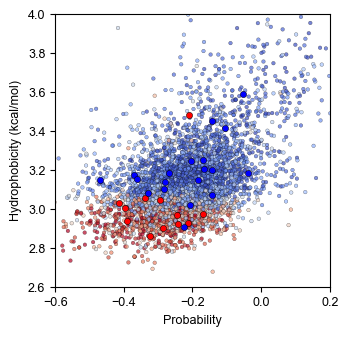

In [10]:
layers = ['inner']
shells = ['membrane']
values = ['hydrophobicity','prob']
summary = ['Mean']

combined = list(itertools.product(*[layers,shells,values,summary]))
names = ['uniprot','Protein name','label'] + ['-'.join(c) for c in combined]
subset = metrics[names]

preds = pd.read_excel(f'{data_folder}/Fig5D-New-prots_above83_accuracy_predictions.xlsx').drop(columns=['Unnamed: 0'])
subset = subset.set_index('uniprot').join(preds[['uniprot','pred_mean']].set_index('uniprot'))

fig,ax = plt.subplots(figsize=[9*cm,9*cm])

x_axis = 'inner-membrane-hydrophobicity-Mean'
y_axis = 'inner-membrane-prob-Mean'
sns.scatterplot(data=subset,x=x_axis,y=y_axis,hue='pred_mean',edgecolor='black',alpha=0.7,s=7,ax=ax,palette='coolwarm_r')

sns.scatterplot(data=subset[subset['label'] == 'bad'],x=x_axis,y=y_axis,color='red',edgecolor='black',alpha=1,s=20,ax=ax)
sns.scatterplot(data=subset[subset['label'] == 'good'],x=x_axis,y=y_axis,color='blue',edgecolor='black',alpha=1,s=20,ax=ax)

plt.xlim([-0.6,0.2])
plt.ylim([2.6,4])

ax.get_legend().remove()
plt.xlabel('Probability')
plt.ylabel('Hydrophobicity (kcal/mol)')
plt.savefig(f'{fig_folder}/Supp_fig-raw_hydro_v_prob.svg',format='svg',dpi=300)

plt.show()
membrane = subset.copy()

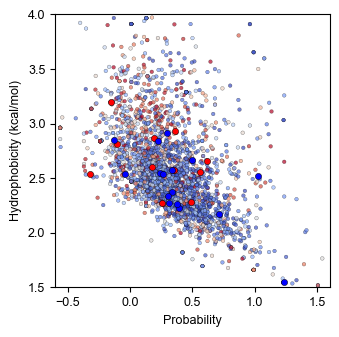

In [11]:
layers = ['water']
shells = ['outside']
values = ['hydrophobicity','prob']
summary = ['Mean']

combined = list(itertools.product(*[layers,shells,values,summary]))
names = ['uniprot','Protein name','label'] + ['-'.join(c) for c in combined]
subset = metrics[names]
subset

preds = pd.read_excel(f'{data_folder}/Fig5D-New-prots_above83_accuracy_predictions.xlsx').drop(columns=['Unnamed: 0'])
subset = subset.set_index('uniprot').join(preds[['uniprot','pred_mean']].set_index('uniprot'))
subset

fig,ax = plt.subplots(figsize=[9*cm,9*cm])

# x_axis = 'inner-membrane-hydrophobicity-Mean'
# y_axis = 'inner-membrane-prob-Mean'
x_axis = names[-2]
y_axis = names[-1]

sns.scatterplot(data=subset,x=x_axis,y=y_axis,hue='pred_mean',edgecolor='black',alpha=0.7,s=7,ax=ax,palette='coolwarm_r')

sns.scatterplot(data=subset[subset['label'] == 'bad'],x=x_axis,y=y_axis,color='red',edgecolor='black',alpha=1,s=20,ax=ax)
sns.scatterplot(data=subset[subset['label'] == 'good'],x=x_axis,y=y_axis,color='blue',edgecolor='black',alpha=1,s=20,ax=ax)

plt.xlim([-0.6,1.6])
plt.ylim([1.5,4])

ax.get_legend().remove()
plt.xlabel('Probability')
plt.ylabel('Hydrophobicity (kcal/mol)')
plt.savefig(f'{fig_folder}/Supp_fig-raw_hydro_v_prob_water.svg',format='svg',dpi=300)

plt.show()
water = subset.copy()

In [28]:
water

,Protein name,label,water-outside-hydrophobicity-Mean,water-outside-prob-Mean,pred_mean
uniprot,,,,,
A0A075B734,NaN,NaN,0.051,2.667,1.000
A0A087WTH1,NaN,NaN,0.170,4.809,0.843
A0A096LPK9,NaN,NaN,0.010,3.382,0.112
A0A0X1KG70,NaN,NaN,0.052,3.079,0.910
A0A1B0GTI8,NaN,NaN,0.494,2.511,0.282
...,...,...,...,...,...
Q9ZWB9,NaN,NaN,0.351,2.587,0.998
Q9ZWD1,NaN,NaN,0.000,0.000,0.872
Q9ZWG1,NaN,NaN,0.000,0.000,0.915


In [37]:
export = membrane.join(water[['water-outside-hydrophobicity-Mean','water-outside-prob-Mean']])
export = export[['Protein name', 'label', 'inner-membrane-hydrophobicity-Mean',
       'inner-membrane-prob-Mean','water-outside-hydrophobicity-Mean', 'water-outside-prob-Mean','pred_mean']]
export = export.rename(columns={'label':'tested','Protein name':'Short name'})
export.to_excel(f'{data_folder}/Supp_Fig_16-raw_prot_feature_values.xlsx')
